# Learning sampling pattern
First version of the full algorithm:
- Only one square image
- Learning points and not shots

In [1]:
from mri.operators import NonCartesianFFT, WaveletUD2, WaveletN
import pysap
from pysap.data import get_sample_data
from mri.operators.utils import convert_mask_to_locations, convert_locations_to_mask
from modopt.math.metrics import ssim
import matplotlib.pyplot as plt
import numpy as np


                 .|'''|       /.\      '||'''|,
                 ||          // \\      ||   ||
'||''|, '||  ||` `|'''|,    //...\\     ||...|'
 ||  ||  `|..||   .   ||   //     \\    ||
 ||..|'      ||   |...|' .//       \\. .||
 ||       ,  |'
.||        ''

Package version: 0.0.3

License: CeCILL-B

Authors: 

Antoine Grigis <antoine.grigis@cea.fr>
Samuel Farrens <samuel.farrens@cea.fr>
Jean-Luc Starck <jl.stark@cea.fr>
Philippe Ciuciu <philippe.ciuciu@cea.fr>

Dependencies: 

scipy          : >=1.3.0   - required | 1.3.0     installed
numpy          : >=1.16.4  - required | 1.16.4    installed
matplotlib     : >=3.0.0   - required | 3.1.1     installed
astropy        : >=3.0.0   - required | 3.2.1     installed
nibabel        : >=2.3.2   - required | 2.5.1     installed
pyqtgraph      : >=0.10.0  - required | 0.10.0    installed
progressbar2   : >=3.34.3  - required | ?         installed
modopt         : >=1.4.0   - required | 1.4.1     installed
scikit-learn   : >=0.19.1  - requi

In [2]:
# Lower level imports
from LowerLevel.prox import prox_G,prox_F1_dual,prox_F2_dual
from LowerLevel.pdhg import pdhg
from LowerLevel.cost_utils import *

#Upper level imports
from scipy.sparse.linalg import cg,LinearOperator
import scipy
import time
from UpperLevel.L1norm import *
from UpperLevel.hessians import *
from scipy.optimize.lbfgsb import fmin_l_bfgs_b
from scipy.stats import norm

In [3]:
u0 = get_sample_data('2d-mri')
n=40
u0_mat = (1+0j)*u0.data[125:125+n,125:125+n]

In [4]:
x = np.linspace(0,n,n,endpoint=False)/n-0.5
y = np.linspace(0,n,n,endpoint=False)/n-0.5
X,Y = np.meshgrid(x,y)
kspace_loc = np.stack([X.flatten('F'),Y.flatten('F')],axis=1)

m = convert_locations_to_mask(kspace_loc,(n,n))
fourier_op = NonCartesianFFT(samples=kspace_loc, shape=(n,n),implementation='cpu')

/home/guillaume/temp/pysap-mri/mri/operators/fourier/utils.py:78: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[test] = 1


### Creation of cartesian mask

In [5]:
x = np.linspace( -0.5, 0.5, n, endpoint = False )
p = np.array([norm.pdf(u,loc=0,scale=0.15) for u in x])
p /= np.sum(p)
y_sampled = np.random.choice( x, size=int(0.7*n), p=p, replace=False)#, p=p

In [6]:
cartesian_p = np.zeros(n**2+1)
for y in y_sampled:
    j=int((y+0.5)*n)
    cartesian_p[j*n:(j+1)*n] = np.ones((n,))
pysap.Image(data=np.reshape(cartesian_p[:-1],(n,n))).show()

In [7]:
#Wavelet
linear_op = WaveletN(wavelet_name="sym8",nb_scale=1,padding_mode = "periodization")
#linear_op = WaveletUD2(wavelet_id=24,nb_scale=3)

param = {"pn1":p[-1],"epsilon":1e-1,"gamma":1e-10}
y = (1+0j)*fourier_op.op(u0_mat)+5e-7*np.random.randn(2*n*n).view(np.complex128)

In [8]:
print(ssim(fourier_op.adj_op(cartesian_p[:-1]*y),u0_mat))
pysap.Image(data=np.abs(u0_mat)).show()

0.9234357997230107


## Loss function and penalty

In [9]:
c = 1e10
def L(u,u2):return c/2 * np.linalg.norm(u.flatten()-u2.flatten())**2
def grad_L(u,u2):return c*(u-u2)


beta = 1e-11*c
def P(p):return beta*np.sum(p[:-1]*(2-p[:-1]))
def grad_P(p):
    Dp = np.zeros(n**2+1)
    Dp[:-1] = 2*beta*(1-p[:-1])
    return Dp

In [10]:
param["pn1"]=5e-7
p = cartesian_p
uk,norms,energy = pdhg(y,p[:-1],fourier_op,linear_op,param,maxit=50,verbose=0)
print(f"\nL(u(p))={L(uk,u0_mat)}\nP(p)={P(p)}")

Sigma: 31.622776601683793 
Tau: 0.015811388300841896


/home/guillaume/pysap-mri/Learning Sampling Pattern/LowerLevel/prox.py:17: RuntimeWarning: invalid value encountered in sqrt
  x/np.abs(x)*(gamma+gamma**2/2/c-gamma/c*np.sqrt((c+0.5*gamma)**2-c*np.abs(x))))


Finished in 0.4197397232055664 seconds.

L(u(p))=5.151713729641647
P(p)=111.99999999999999


# Upper level energy

In [11]:
def E(pk,**kwargs):
    print("\nEvaluating E(p)")
    # Getting parameters
    uk = kwargs.get("uk",None)       

    #Computing E(p)
    if uk is None:
        print("\nStarting PDHG")
        param["pn1"]=pk[-1]
        uk,_ = pdhg(y,pk[:-1],fourier_op,linear_op,param,compute_energy=False,maxit=50,verbose=0)
    
    return L(uk,u0_mat)+P(pk)

In [12]:
E(cartesian_p)


Evaluating E(p)

Starting PDHG
Sigma: 31.622776601683793 
Tau: 0.015811388300841896


/home/guillaume/pysap-mri/Learning Sampling Pattern/LowerLevel/prox.py:17: RuntimeWarning: divide by zero encountered in double_scalars
  x/np.abs(x)*(gamma+gamma**2/2/c-gamma/c*np.sqrt((c+0.5*gamma)**2-c*np.abs(x))))
/home/guillaume/pysap-mri/Learning Sampling Pattern/LowerLevel/prox.py:17: RuntimeWarning: invalid value encountered in subtract
  x/np.abs(x)*(gamma+gamma**2/2/c-gamma/c*np.sqrt((c+0.5*gamma)**2-c*np.abs(x))))


Finished in 0.2602653503417969 seconds.


117.07990262520815

In [13]:
def grad_E(pk,**kwargs):
    # -- Getting parameters
    max_cgiter = kwargs.get("max_cgiter",5000)
    cgtol = kwargs.get("cgtol",1e-6)
    compute_conv = kwargs.get("compute_conv",False)
    uk = kwargs.get("uk",None)
    cg_conv = []
    
    
    # -- Compute uk from pk with lower level solver if not given
    if uk is None:
        print("\nStarting PDHG")
        param["pn1"]=pk[-1]
        uk,_ = pdhg(y,pk[:-1],fourier_op,linear_op,param,compute_energy=False,maxit=50,verbose=0)
    
    # -- Defining linear operator from pk and uk
    def mv(w):
        w_complex = np.reshape( w[:n**2]+1j*w[n**2:] , (n,n) )
        fx = np.reshape(Du2_Etot( uk , pk , w_complex ,
                                   eps=param["epsilon"],
                                   fourier_op=fourier_op,
                                   y=y,
                                   linear_op=linear_op,
                                   gamma=param["gamma"]),(n**2,))
        return np.concatenate([np.real(fx),np.imag(fx)])
    lin = LinearOperator((2*n**2,2*n**2),matvec=mv)


    print("\nStarting Conjugate Gradient method")
    t1=time.time()
    B = np.reshape(grad_L(uk,u0_mat),(n**2,))
    B_real = np.concatenate([np.real(B),np.imag(B)])
    def cgcall(x):
        #CG callback function to plot convergence
        if compute_conv:cg_conv.append(np.linalg.norm(lin(x)-B_real)/np.linalg.norm(B_real))
    
    x_inter,convergence = scipy.sparse.linalg.cg(lin,B_real,tol=cgtol,maxiter=max_cgiter,callback=cgcall)
    print(f"Finished in {time.time()-t1}s - ||Ax-b||/||b||: {np.linalg.norm(lin(x_inter)-B_real)/np.linalg.norm(B_real)}")

    gradE = -Dpu_Etot(uk,pk,np.reshape( x_inter[:n**2]+1j*x_inter[n**2:] , (n,n) ),
                               eps=param["epsilon"],
                               fourier_op=fourier_op,
                               y=y,
                               linear_op=linear_op,
                               gamma=param["gamma"])
    
    # -- Apply DpuE
    gradE += grad_P(pk)
    
    if compute_conv:return gradE,cg_conv
    else:return gradE

In [14]:
#Checking if conjugate gradient converges
cgconv = []
#p=0.7*cartesian_p+0.3*np.random.rand(n**2+1)
p = np.random.rand(n**2+1)

param["epsilon"] = 1e1
param["pn1"]=1e-6
p[-1]=1e-6
print( p[ -1 ] )
gP, cg_conv = grad_E(p,max_cgiter=5000,cgtol=1e-8, compute_conv = True)

1e-06

Starting PDHG
Sigma: 31.622776601683793 
Tau: 0.015811388300841896
Finished in 0.2091052532196045 seconds.

Starting Conjugate Gradient method
Finished in 1.6354198455810547s - ||Ax-b||/||b||: 6.015402262268623e-09


Text(0, 0.5, '||Ax-b||/||b||')

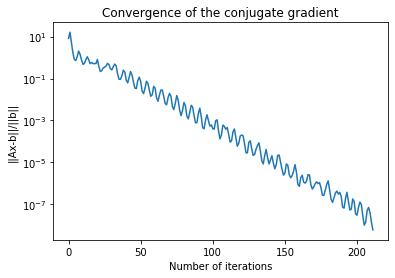

In [15]:
plt.plot(cg_conv)
plt.yscale("log")
plt.title("Convergence of the conjugate gradient")
plt.xlabel("Number of iterations")
plt.ylabel("||Ax-b||/||b||")
#plt.savefig("Upper Level/CG_conv.png")

In [16]:
# Checking gradE
#ptest = np.random.rand(n**2+1)
ptest = 0.5*cartesian_p+0.5*np.random.rand(n**2+1)
ptest[-1]=1e-6

param["epsilon"] = 1e2
param["pn1"] = ptest[-1]
ukptest,_ = pdhg(y,ptest[:-1],fourier_op,linear_op,param,compute_energy=False,maxit=50,verbose=0)
Eptest,gradEptest = E(ptest,uk=ukptest),grad_E(ptest,uk=ukptest)

p1 = np.random.rand(n**2+1)
p1[-1] = 1e-6
tests = np.logspace(-10,0,30)
real_values = np.array([E(ptest+t*p1) for t in tests])
approx = np.array([Eptest+np.sum(gradEptest*t*p1) for t in tests])

Sigma: 31.622776601683793 
Tau: 0.015811388300841896
Finished in 0.15050411224365234 seconds.

Evaluating E(p)

Starting Conjugate Gradient method
Finished in 0.35747599601745605s - ||Ax-b||/||b||: 9.18933273500147e-07

Evaluating E(p)

Starting PDHG
Sigma: 31.622776601683793 
Tau: 0.015811388300841896
Finished in 0.09972071647644043 seconds.

Evaluating E(p)

Starting PDHG
Sigma: 31.622776601683793 
Tau: 0.015811388300841896
Finished in 0.14201688766479492 seconds.

Evaluating E(p)

Starting PDHG
Sigma: 31.622776601683793 
Tau: 0.015811388300841896
Finished in 0.10373306274414062 seconds.

Evaluating E(p)

Starting PDHG
Sigma: 31.622776601683793 
Tau: 0.015811388300841896
Finished in 0.11533427238464355 seconds.

Evaluating E(p)

Starting PDHG
Sigma: 31.622776601683793 
Tau: 0.015811388300841896
Finished in 0.10042023658752441 seconds.

Evaluating E(p)

Starting PDHG
Sigma: 31.622776601683793 
Tau: 0.015811388300841896
Finished in 0.12255454063415527 seconds.

Evaluating E(p)

Startin

634.4945804429877


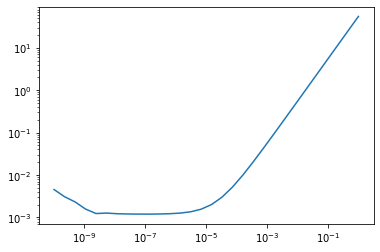

In [17]:
print(Eptest)
plt.plot(tests,abs((real_values-approx))/tests)
plt.xscale("log")
plt.yscale("log")

# L-BFGS-B

In [18]:
p0 = np.random.rand(n**2+1)
#p0=0.5*cartesian_p+0.5*np.random.rand(n**2+1)
#p0=np.ones(n**2+1)
p0[-1] = 1e-7
param["epsilon"] = 1e-1

# Callback function
niter = 0
energy_upper = [E(p0)]
alphas = [p0[-1]]
def fcall(x):
    global uk,niter
    niter += 1
    Ep = E(x)
    energy_upper.append(Ep)
    alphas.append(x[-1])
    print("\033[1m" + f"\n{niter} iterations: E(p)={Ep}, alpha={x[-1]}\n\n" + "\033[0m")


Evaluating E(p)

Starting PDHG
Sigma: 31.622776601683793 
Tau: 0.015811388300841896
Finished in 0.19347167015075684 seconds.


In [19]:
niter = 0
energy_upper = [E(p0)]
alphas = [p0[-1]]
pf,Emin,info = fmin_l_bfgs_b(E,p0,grad_E,bounds=[(0,1)]*n**2+[(1e-10,np.inf)],pgtol=1e-15,
                             maxfun=10,maxiter=20,
                             callback = fcall)


Evaluating E(p)

Starting PDHG
Sigma: 31.622776601683793 
Tau: 0.015811388300841896
Finished in 0.18211126327514648 seconds.

Evaluating E(p)

Starting PDHG
Sigma: 31.622776601683793 
Tau: 0.015811388300841896
Finished in 0.18330049514770508 seconds.

Starting PDHG
Sigma: 31.622776601683793 
Tau: 0.015811388300841896
Finished in 0.16299772262573242 seconds.

Starting Conjugate Gradient method
Finished in 0.8417220115661621s - ||Ax-b||/||b||: 9.993968068030664e-07

Evaluating E(p)

Starting PDHG
Sigma: 31.622776601683793 
Tau: 0.015811388300841896
Finished in 0.1601550579071045 seconds.

Starting PDHG
Sigma: 31.622776601683793 
Tau: 0.015811388300841896
Finished in 0.17744779586791992 seconds.

Starting Conjugate Gradient method
Finished in 0.6079864501953125s - ||Ax-b||/||b||: 8.371515257026683e-07

Evaluating E(p)

Starting PDHG
Sigma: 31.622776601683793 
Tau: 0.015811388300841896
Finished in 0.16151213645935059 seconds.

1 iterations: E(p)=169.15362320016388, alpha=8.045915764275865

Finished in 0.18007493019104004 seconds.

Starting Conjugate Gradient method
Finished in 2.042534828186035s - ||Ax-b||/||b||: 7.68093882745445e-07

Evaluating E(p)

Starting PDHG
Sigma: 31.622776601683793 
Tau: 0.015811388300841896
Finished in 0.16054964065551758 seconds.

Starting PDHG
Sigma: 31.622776601683793 
Tau: 0.015811388300841896
Finished in 0.17226815223693848 seconds.

Starting Conjugate Gradient method
Finished in 2.090956211090088s - ||Ax-b||/||b||: 7.549246233314016e-07

Evaluating E(p)

Starting PDHG
Sigma: 31.622776601683793 
Tau: 0.015811388300841896
Finished in 0.16088533401489258 seconds.

Starting PDHG
Sigma: 31.622776601683793 
Tau: 0.015811388300841896
Finished in 0.17118453979492188 seconds.

Starting Conjugate Gradient method
Finished in 2.0052454471588135s - ||Ax-b||/||b||: 9.901507277117556e-07

Evaluating E(p)

Starting PDHG
Sigma: 31.622776601683793 
Tau: 0.015811388300841896
Finished in 0.16084885597229004 seconds.

Starting PDHG
Sigma: 31.622776601683793 


Finished in 0.17783665657043457 seconds.

Starting Conjugate Gradient method
Finished in 0.014737606048583984s - ||Ax-b||/||b||: 5.901059496508695e-07

Evaluating E(p)

Starting PDHG
Sigma: 31.622776601683793 
Tau: 0.015811388300841896
Finished in 0.16094732284545898 seconds.

Starting PDHG
Sigma: 31.622776601683793 
Tau: 0.015811388300841896
Finished in 0.1739821434020996 seconds.

Starting Conjugate Gradient method
Finished in 0.018323898315429688s - ||Ax-b||/||b||: 2.461273120306484e-09

Evaluating E(p)

Starting PDHG
Sigma: 31.622776601683793 
Tau: 0.015811388300841896
Finished in 0.16045928001403809 seconds.

Starting PDHG
Sigma: 31.622776601683793 
Tau: 0.015811388300841896
Finished in 0.17271733283996582 seconds.

Starting Conjugate Gradient method
Finished in 0.01832437515258789s - ||Ax-b||/||b||: 2.833716100147531e-08



Evaluating E(p)

Starting PDHG
Sigma: 31.622776601683793 
Tau: 0.015811388300841896
Finished in 0.20958614349365234 seconds.

Evaluating E(p)

Starting PDHG
Sigma: 31.622776601683793 
Tau: 0.015811388300841896
Finished in 0.16445493698120117 seconds.
211.1466950913742 96.37969643419477


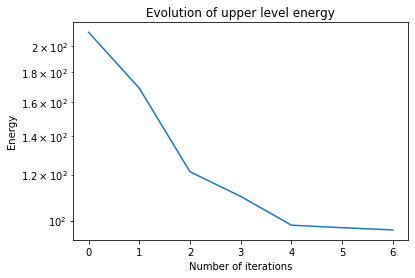

In [20]:
print(E(p0),E(pf))
plt.plot(energy_upper)
plt.title("Evolution of upper level energy")
plt.xlabel("Number of iterations")
plt.ylabel("Energy")
plt.yscale("log")
#plt.savefig("Results/Upper Level/Penalty_strength_V2/med_pen/convergence.png")

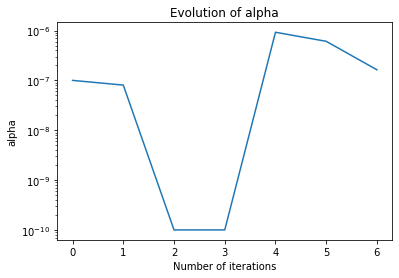

In [21]:
plt.plot(alphas)
plt.title("Evolution of alpha")
plt.xlabel("Number of iterations")
plt.ylabel("alpha")
plt.yscale("log")
#plt.savefig("Results/Upper Level/Penalty_strength_V2/med_pen/alpha.png")

In [22]:
print(pf[-1])
pysap.Image(data=np.reshape(pf[:-1],(n,n))).show()

1.631004783801487e-07


In [23]:
P(pf),E(pf),np.sum(pf)


Evaluating E(p)

Starting PDHG
Sigma: 31.622776601683793 
Tau: 0.015811388300841896
Finished in 0.3833134174346924 seconds.


(88.57234037233735, 96.37969643419477, 664.8393871058267)

In [24]:
param["pn1"]=pf[-1]
uk,norms,energy,ssims = pdhg(y,pf[:-1],fourier_op,linear_op,param,ground_truth=u0_mat,maxit=200)

Sigma: 31.622776601683793 
Tau: 0.015811388300841896
10  iterations:
Cost: 6.053360392683299e-09 
Norm: 0.03726623080269017 

20  iterations:
Cost: 5.93755776995473e-09 
Norm: 0.03063690959629649 

30  iterations:
Cost: 5.855047535233072e-09 
Norm: 0.020885689621044 

40  iterations:
Cost: 5.79617975672315e-09 
Norm: 0.01780445540232026 

50  iterations:
Cost: 5.754115749868462e-09 
Norm: 0.014174624589846717 

60  iterations:
Cost: 5.723998831954826e-09 
Norm: 0.011142514323081191 

70  iterations:
Cost: 5.7023861186159414e-09 
Norm: 0.009210760466881872 

80  iterations:
Cost: 5.686835480649728e-09 
Norm: 0.008455720696970736 

90  iterations:
Cost: 5.675608389815319e-09 
Norm: 0.007373287574116954 

100  iterations:
Cost: 5.667463151758357e-09 
Norm: 0.005117324719726792 

110  iterations:
Cost: 5.661519746031038e-09 
Norm: 0.005336885317570168 

120  iterations:
Cost: 5.657160487590165e-09 
Norm: 0.004569500306472884 

130  iterations:
Cost: 5.653937721496378e-09 
Norm: 0.003521316

0.8866305262643198


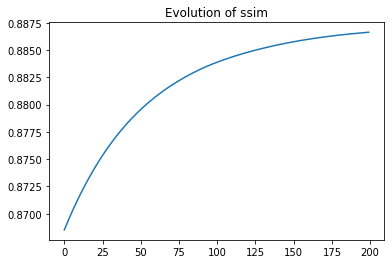

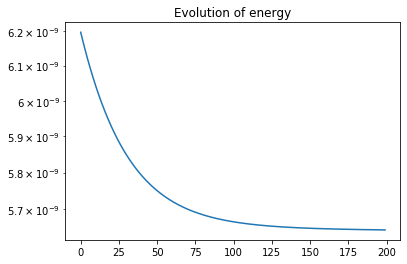

In [25]:
print(ssim(uk,u0_mat))

plt.figure()
plt.plot(ssims)
plt.title("Evolution of ssim")
plt.show()

plt.figure()
plt.plot(energy)
plt.title("Evolution of energy")
plt.yscale("log")
plt.show()

pysap.Image(data=uk).show()